# DQN_v4: 芝加哥房地产价格估算的深度Q网络

本Notebook将DQN_v2的架构迁移至新的芝加哥房地产数据集。整体流程与DQN_v2保持一致，包括数据预处理、线性回归基准模型、强化学习环境设计、PyTorch下的DQN模型定义、训练与评估。目标是训练一个DQN智能体，在基准估价的基础上学习价格调整策略，提升房价预测的准确性。本项目所有价格均以“美元”为单位。

## DQN_v4.2 — Late Fusion (文本与数值特征独立子网络)
核心思路：

1. 数值特征流 -> 全连接层提取特征向量。

2. SBERT嵌入流 -> 单独全连接层降维。

3. 两者在中间层融合（拼接）。

4. 合并后进入DQN决策层。

## Part 1: 数据预处理  (Numerical + SBERT Text Features)
首先加载芝加哥房地产数据集（real_estate_data_chicago.csv），并对数据进行清洗与特征工程。本次实验中，仅使用数值型特征，不考虑文本描述与类别型特征（text特征将在后续版本DQN_v5中引入）。我们选用以下9个输入特征：

- year_built：建筑年份

- beds：卧室数量

- baths：卫生间总数（full + half）

- baths_full：全卫数量

- baths_half：半卫数量

- garage：车库数量

- lot_sqft：土地面积（平方英尺）

- sqft：房屋室内面积（平方英尺）

- stories：楼层数

预测目标有两个：

1. 总价（listPrice，单位美元）

2. 单价（price，按listPrice / sqft计算，单位美元/平方英尺）

预处理步骤：

1. 加载数据并计算price（listPrice / sqft）。

2. 删除listPrice或sqft缺失的数据。

3. 对于year_built、lot_sqft、stories等特征用中位数填充缺失值。

4. 对baths_half与garage缺失值用0填充（代表无半卫或车库）。

5. 训练集与测试集按80/20划分，确保随机种子固定（42）。

6. 准备好特征矩阵X与目标变量y。


任务目标：加载并预处理Chicago房地产数据，将结构化数值特征与SBERT文本嵌入结合，作为DQN模型输入
 - 读取CSV数据
 - 填补缺失值与特征清洗
 - 使用SentenceTransformer将text字段编码为向量
 - 划分训练集与测试集，并分别提取数值特征与文本特征

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import os
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
random.seed(42)
np.random.seed(42)

# 读取数据
df = pd.read_csv('real_estate_data_chicago.csv')
df['price'] = df['listPrice'] / df['sqft']
df = df.dropna(subset=['listPrice', 'sqft'])

# 填充缺失值（与v4.1一致）
df['year_built'] = df['year_built'].fillna(df['year_built'].median())
df['baths'] = df['baths'].fillna(df['baths_full'] + 0.5 * df['baths_half'].fillna(0))
df['baths_full'] = df['baths_full'].fillna(df['baths'].round().fillna(0))
df['baths_half'] = df['baths_half'].fillna(0)
df['garage'] = df['garage'].fillna(0)
df['lot_sqft'] = df['lot_sqft'].fillna(df['lot_sqft'].median())
df['stories'] = df['stories'].fillna(df['stories'].median())

# 特征定义
numerical_features = ['year_built', 'beds', 'baths', 'baths_full', 'baths_half', 'garage', 'lot_sqft', 'sqft', 'stories']
target_total = 'listPrice'
target_price = 'price'

# SBERT 文本嵌入
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
df['text'] = df['text'].fillna('')
text_embeddings = sbert_model.encode(df['text'].tolist(), batch_size=32, show_progress_bar=True)
text_emb_matrix = np.vstack(text_embeddings)

# 划分训练与测试集
train_df, test_df, train_text_emb, test_text_emb = train_test_split(df, text_emb_matrix, test_size=0.2, random_state=42)

# 数值特征流
X_train_num = train_df[numerical_features].values
X_test_num = test_df[numerical_features].values

# 文本特征流 (SBERT)
X_train_text = train_text_emb
X_test_text = test_text_emb

# 目标变量
y_train_total = train_df[target_total].values
y_test_total = test_df[target_total].values
y_train_price = train_df[target_price].values
y_test_price = test_df[target_price].values

print(f"训练集大小: {X_train_num.shape[0]}, 测试集大小: {X_test_num.shape[0]}")

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

C:\Users\Thinkpad\anaconda3\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


训练集大小: 1155, 测试集大小: 289


## Part 2: 线性回归基准模型

在进入强化学习前，先训练一个简单的线性回归模型，用于预测每平方英尺价格（price）。线性模型的输出将作为DQN的初始估价（base_price）。

具体步骤：

1. 用训练集特征X_train与目标y_train_price（单价）训练线性回归模型。

2. 预测训练集与测试集的单价，并乘以sqft得到总价预测（base_price）。

3. 计算基准模型在测试集上的MAE与RMSE。

4. 打印部分测试样本的实际价格与基准预测价格。



In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

linreg = LinearRegression()
linreg.fit(X_train_num, y_train_price)

pred_train_price = linreg.predict(X_train_num)
pred_test_price = linreg.predict(X_test_num)

# Base Prices (Total Price = Unit Price * Sqft)
base_price_train = pred_train_price * train_df['sqft'].values
base_price_test = pred_test_price * test_df['sqft'].values

# Baseline Performance Metrics
baseline_mae = mean_absolute_error(y_test_total, base_price_test)
baseline_rmse = mean_squared_error(y_test_total, base_price_test, squared=False)

print(f"Baseline Model MAE: ${baseline_mae:,.0f}")
print(f"Baseline Model RMSE: ${baseline_rmse:,.0f}")



Baseline Model MAE: $247,652
Baseline Model RMSE: $732,408


## Part 3: Defining the Late Fusion DQN Network

### 任务目标：构建DQN网络，采用Late Fusion架构，分别处理数值特征与SBERT文本嵌入流
 - 数值特征流：全连接层降维
 - 文本特征流：全连接层降维
 - 融合层：将两种特征拼接后，输出动作Q值


In [3]:
class DQNNetLateFusion(nn.Module):
    def __init__(self, num_input_dim, text_input_dim, output_dim):
        super(DQNNetLateFusion, self).__init__()
        # Numerical Feature Stream
        self.num_fc = nn.Sequential(
            nn.Linear(num_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        # Text Embedding Stream
        self.text_fc = nn.Sequential(
            nn.Linear(text_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        # Fusion Layer
        self.fc_final = nn.Linear(128, output_dim)

    def forward(self, num_x, text_x):
        num_feat = self.num_fc(num_x)
        text_feat = self.text_fc(text_x)
        fused = torch.cat([num_feat, text_feat], dim=1)
        q_values = self.fc_final(fused)
        return q_values

## Part 4: Environment Definition
### 任务目标：定义强化学习环境，用于模拟房价估值行为
 - reset(): 随机初始化一个样本状态 (数值特征 + 文本特征)
 - step(action): 应用调整动作后，返回reward与新状态

In [4]:
adjustments = [-0.20, -0.10, -0.05, 0.0, 0.05, 0.10, 0.20]

# Define device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

episode_losses = []
episode_rewards = []

from collections import deque

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
        
    def __len__(self):
        return len(self.buffer)

class HousingPricingEnv:
    def __init__(self, states_num, states_text, true_prices, base_prices, adjustments):
        self.states_num = states_num
        self.states_text = states_text
        self.true_prices = true_prices
        self.base_prices = base_prices
        self.actions = adjustments
        self.n = len(states_num)

    def reset(self):
        self.idx = np.random.randint(0, self.n)
        self.current_state_num = self.states_num[self.idx]
        self.current_state_text = self.states_text[self.idx]
        self.true_price = self.true_prices[self.idx]
        self.current_guess = self.base_prices[self.idx]
        return self.current_state_num, self.current_state_text

    def step(self, action_idx):
        adjustment = self.actions[action_idx]
        self.current_guess *= (1 + adjustment)
        diff = abs(self.current_guess - self.true_price)
        reward = -diff / 10000  # 将价格差异归一化到“万元”
        if abs(adjustment) > 0.1:
            reward -= 5.0  # 过大调整将给予惩罚
        done = True
        return (self.current_state_num, self.current_state_text), reward, done
    


Using device: cpu


## Part 5: DQN训练过程

In [5]:
def train_dqn(config, X_num_train, X_text_train, y_total_train, base_price_train, adjustments):
    state_dim_num = X_num_train.shape[1]
    state_dim_text = X_text_train.shape[1]
    action_dim = len(adjustments)

    policy_net = DQNNetLateFusion(state_dim_num, state_dim_text, action_dim).to(device)
    target_net = DQNNetLateFusion(state_dim_num, state_dim_text, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=config['learning_rate'])
    memory = ReplayBuffer(config['replay_buffer_size'])

    epsilon = config['epsilon_start']
    steps_done = 0
    all_losses = []

    env = HousingPricingEnv(X_num_train, X_text_train, y_total_train, base_price_train, adjustments)

    for i_episode in range(1, config['num_episodes'] + 1):
        state_num, state_text = env.reset()
        episode_loss = 0.0
        episode_steps = 0

        while True:
            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                num_tensor = torch.FloatTensor(state_num).unsqueeze(0).to(device)
                text_tensor = torch.FloatTensor(state_text).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = policy_net(num_tensor, text_tensor)
                action = q_values.argmax(dim=1).item()

            (next_state_num, next_state_text), reward, done = env.step(action)
            memory.push((state_num, state_text), action, reward, (next_state_num, next_state_text), done)
            state_num, state_text = next_state_num, next_state_text

            steps_done += 1
            epsilon = config['epsilon_end'] + (config['epsilon_start'] - config['epsilon_end']) * math.exp(-1.0 * steps_done / config['epsilon_decay'])

            if len(memory) >= config['batch_size']:
                transitions = memory.sample(config['batch_size'])
                batch_num_state = torch.FloatTensor([t[0][0] for t in transitions]).to(device)
                batch_text_state = torch.FloatTensor([t[0][1] for t in transitions]).to(device)
                batch_action = torch.LongTensor([t[1] for t in transitions]).to(device)
                batch_reward = torch.FloatTensor([t[2] for t in transitions]).to(device)
                batch_next_num_state = torch.FloatTensor([t[3][0] for t in transitions]).to(device)
                batch_next_text_state = torch.FloatTensor([t[3][1] for t in transitions]).to(device)
                batch_done = torch.FloatTensor([1.0 if t[4] else 0.0 for t in transitions]).to(device)

                q_values = policy_net(batch_num_state, batch_text_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(batch_next_num_state, batch_next_text_state).max(1)[0]
                target_q_values = batch_reward + config['gamma'] * next_q_values * (1 - batch_done)

                loss = nn.MSELoss()(q_values, target_q_values.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                episode_loss += loss.item()
                episode_steps += 1

            if done:
                break

        avg_loss = episode_loss / episode_steps if episode_steps > 0 else 0.0
        all_losses.append(avg_loss)

        if i_episode % config['target_update_freq'] == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return all_losses, policy_net  # 返回loss和训练后的policy_net


### Part 5.1 Grid调参
每轮训练步骤：

1. 环境随机抽取一个房产作为state。

2. 按ε-贪婪策略选择一个动作（百分比调整）。

3. 环境返回调整后估价与reward（负误差）。

4. 将(state, action, reward, next_state, done)存入回放池。

5. 从回放池中采样批量数据进行DQN更新。

6. 每隔固定轮次更新target_net。

7. 记录每轮的reward与loss，并定期输出训练进度。

In [7]:
import matplotlib.pyplot as plt
import os

# 超参数网格
# Round 1
'''learning_rates = [1e-4, 5e-4, 1e-3, 2e-3]
batch_sizes = [32, 64, 128]  # 64最佳
gammas = [0.95, 0.99, 0.995, 0.975]
epsilon_decays = [200, 700, 1500, 2500]
target_update_freq = [2, 5, 10]'''

learning_rates = [1e-4]
batch_sizes = [32]  # 64最佳
gammas = [0.975]
epsilon_decays = [200]
target_update_freq = [10]

os.makedirs("grid_search_results_v4.2", exist_ok=True)

config = {
    'num_episodes': 300,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'replay_buffer_size': 10000
}

for lr in learning_rates:
    for bs in batch_sizes:
        for gm in gammas:
            for ed in epsilon_decays:
                for tuf in target_update_freq:
                    config.update({
                        'learning_rate': lr,
                        'batch_size': bs,
                        'gamma': gm,
                        'epsilon_decay': ed,
                        'target_update_freq': tuf
                    })
                    print(f"Training: LR={lr}, BS={bs}, Gamma={gm}, EpsDecay={ed}, TUF={tuf}")

                    # Initialize network and environment
                    state_dim_num = X_train_num.shape[1]
                    state_dim_text = X_train_text.shape[1]
                    action_dim = len(adjustments)

                    policy_net = DQNNetLateFusion(state_dim_num, state_dim_text, action_dim).to(device)
                    target_net = DQNNetLateFusion(state_dim_num, state_dim_text, action_dim).to(device)
                    target_net.load_state_dict(policy_net.state_dict())
                    target_net.eval()

                    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
                    memory = ReplayBuffer(config['replay_buffer_size'])

                    epsilon = config['epsilon_start']
                    steps_done = 0
                    all_losses = []

                    env = HousingPricingEnv(X_train_num, X_train_text, y_train_total, base_price_train, adjustments)

                    for i_episode in range(1, config['num_episodes'] + 1):
                        state_num, state_text = env.reset()
                        episode_loss = 0.0
                        episode_steps = 0

                        while True:
                            if random.random() < epsilon:
                                action = random.randrange(action_dim)
                            else:
                                num_tensor = torch.FloatTensor(state_num).unsqueeze(0).to(device)
                                text_tensor = torch.FloatTensor(state_text).unsqueeze(0).to(device)
                                with torch.no_grad():
                                    q_values = policy_net(num_tensor, text_tensor)
                                action = q_values.argmax(dim=1).item()

                            (next_state_num, next_state_text), reward, done = env.step(action)
                            memory.push((state_num, state_text), action, reward, (next_state_num, next_state_text), done)
                            state_num, state_text = next_state_num, next_state_text

                            steps_done += 1
                            epsilon = config['epsilon_end'] + (config['epsilon_start'] - config['epsilon_end']) * math.exp(-1.0 * steps_done / config['epsilon_decay'])

                            if len(memory) >= config['batch_size']:
                                transitions = memory.sample(config['batch_size'])
                                batch_num_state = torch.FloatTensor([t[0][0] for t in transitions]).to(device)
                                batch_text_state = torch.FloatTensor([t[0][1] for t in transitions]).to(device)
                                batch_action = torch.LongTensor([t[1] for t in transitions]).to(device)
                                batch_reward = torch.FloatTensor([t[2] for t in transitions]).to(device)
                                batch_next_num_state = torch.FloatTensor([t[3][0] for t in transitions]).to(device)
                                batch_next_text_state = torch.FloatTensor([t[3][1] for t in transitions]).to(device)
                                batch_done = torch.FloatTensor([1.0 if t[4] else 0.0 for t in transitions]).to(device)

                                q_values = policy_net(batch_num_state, batch_text_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                                next_q_values = target_net(batch_next_num_state, batch_next_text_state).max(1)[0]
                                target_q_values = batch_reward + gm * next_q_values * (1 - batch_done)

                                loss = nn.MSELoss()(q_values, target_q_values.detach())
                                optimizer.zero_grad()
                                loss.backward()
                                optimizer.step()

                                episode_loss += loss.item()
                                episode_steps += 1

                            if done:
                                break

                        avg_loss = episode_loss / episode_steps if episode_steps > 0 else 0.0
                        all_losses.append(avg_loss)

                        if i_episode % tuf == 0:
                            target_net.load_state_dict(policy_net.state_dict())

                    # Plot Loss Curve
                    plt.figure()
                    plt.plot(all_losses)
                    plt.ylim(0, 50000)
                    plt.title(f"DQN Training Loss\nLR={lr}, BS={bs}, Gamma={gm}, EpsDecay={ed}, TUF={tuf}")
                    plt.xlabel("Episode")
                    plt.ylabel("Loss")

                    folder = "grid_search_results_v4.2"
                    file_name = f"loss_lr{lr}_bs{bs}_gm{gm}_ed{ed}_tuf{tuf}.png".replace(".", "p")
                    fname = os.path.join(folder, file_name)

                    plt.savefig(fname)
                    plt.close()


Training: LR=0.0001, BS=32, Gamma=0.975, EpsDecay=200, TUF=10


C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_29688\29675612.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  batch_num_state = torch.FloatTensor([t[0][0] for t in transitions]).to(device)


### Part 5.2: Select Best Hyperparameters for Final Training

开始使用最佳超参数重新训练DQN模型...


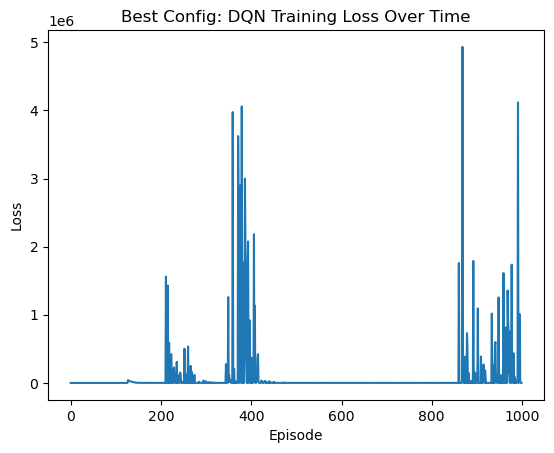

In [18]:
# Part 5.2: 选定最佳参数后，进行完整训练 (用于后续评估)
best_config = {
    'num_episodes': 1000,
    'learning_rate': 0.0001,
    'batch_size': 128,
    'gamma': 0.975,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 700,
    'target_update_freq': 5,
    'replay_buffer_size': 10000
}

print("开始使用最佳超参数重新训练DQN模型...")
final_losses, trained_policy_net = train_dqn(best_config, X_train_num, X_train_text, y_train_total, base_price_train, adjustments)


# 绘制最终训练Loss曲线
plt.plot(final_losses)
plt.title("Best Config: DQN Training Loss Over Time")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.show()

## Part 6: 模型评估与可视化

V4.2输入是数值特征+SBERT文本特征，因此在预测部分也要相应改为双流输入

Baseline Model MAE: $247,652
Baseline Model RMSE: $732,408
DQN Agent MAE: $250,945
DQN Agent RMSE: $704,206


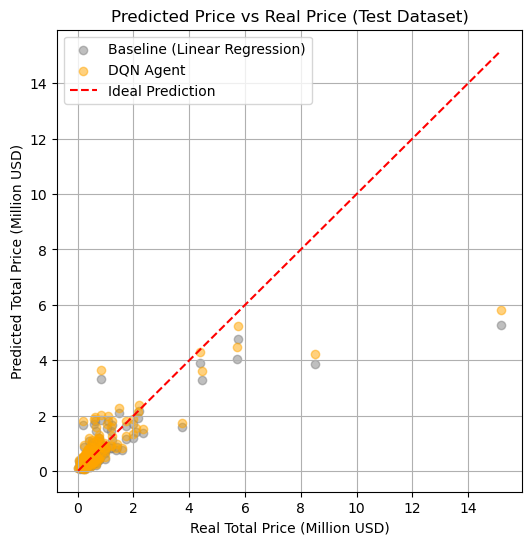

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in evaluation mode
trained_policy_net.eval()

# Predict prices for the entire test set (V4.2 Late Fusion)
agent_pred_prices = []
for i in range(X_test_num.shape[0]):
    state_num = X_test_num[i]
    state_text = X_test_text[i]
    base_price = base_price_test[i]

    state_num_t = torch.FloatTensor(state_num).unsqueeze(0).to(device)
    state_text_t = torch.FloatTensor(state_text).unsqueeze(0).to(device)

    with torch.no_grad():
        q_vals = policy_net(state_num_t, state_text_t)

    with torch.no_grad():
        q_vals = trained_policy_net(state_num_t, state_text_t)
    best_action = q_vals.argmax(dim=1).item()
    adjustment = adjustments[best_action]
    pred_price = base_price * (1 + adjustment)
    agent_pred_prices.append(pred_price)

agent_pred_prices = np.array(agent_pred_prices)

# Evaluation Metrics (USD)
agent_mae = mean_absolute_error(y_test_total, agent_pred_prices)
agent_rmse = mean_squared_error(y_test_total, agent_pred_prices, squared=False)

print(f"Baseline Model MAE: ${baseline_mae:,.0f}")
print(f"Baseline Model RMSE: ${baseline_rmse:,.0f}")
print(f"DQN Agent MAE: ${agent_mae:,.0f}")
print(f"DQN Agent RMSE: ${agent_rmse:,.0f}")

# Determine sample size dynamically based on test set size
sample_size = min(1000, len(y_test_total))
sample_idx = np.random.choice(len(y_test_total), size=sample_size, replace=False)

actual_prices_sample = y_test_total[sample_idx] / 1_000_000
baseline_prices_sample = base_price_test[sample_idx] / 1_000_000
dqn_pred_prices_sample = agent_pred_prices[sample_idx] / 1_000_000

# Scatter Plot: Predicted vs Real Price (Baseline vs DQN)
plt.figure(figsize=(6,6))
plt.scatter(actual_prices_sample, baseline_prices_sample, color='gray', alpha=0.5, label='Baseline (Linear Regression)')
plt.scatter(actual_prices_sample, dqn_pred_prices_sample, color='orange', alpha=0.5, label='DQN Agent')

# Ideal prediction line (y = x)
min_val = actual_prices_sample.min()
max_val = actual_prices_sample.max()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')

plt.xlabel("Real Total Price (Million USD)")
plt.ylabel("Predicted Total Price (Million USD)")
plt.title("Predicted Price vs Real Price (Test Dataset)")
plt.legend()
plt.grid(True)
plt.show()


## Part 7: 用户输入房产参数估值

最后，我们实现一个接口，允许用户输入房产的特征参数，利用已训练的模型输出该房产的估计价格并解释估值过程。这里我们以字典构造一个示例输入（在实际应用中可以用交互式表单获取用户输入），然后按照与训练数据相同的预处理方式转换特征，经过线性模型和DQN智能体两步得到最终估价。我们将打印每平米单价的线性估计、基础总价以及DQN的调整幅度和最终总价，以帮助用户理解估值过程。

In [ ]:
from sentence_transformers import SentenceTransformer

# 示例用户输入的房产参数（实际应用中可替换为用户交互输入）
user_input = {
    'year_built': 1995,
    'beds': 3,
    'baths': 2,
    'baths_full': 2,
    'baths_half': 0,
    'garage': 1,
    'lot_sqft': 5000,
    'sqft': 1800,
    'stories': 2,
    'description': "Beautifully renovated home with modern kitchen and hardwood floors. Spacious backyard and close to public transport."
}

# 将输入按照与训练数据相同的方式进行处理
numerical_array = np.array([user_input[feature] for feature in numerical_features], dtype=float).reshape(1, -1)

# 使用SBERT将文本描述编码为向量
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
text_embedding = sbert_model.encode([user_input['description']])

# 1) 线性回归模型估计每平方英尺价格和基础总价
est_price_per_sqft = linreg.predict(numerical_array)[0]
base_total_price = est_price_per_sqft * user_input['sqft']

# 2) DQN智能体根据状态选择调整动作并给出最终估价
policy_net.eval()
numerical_tensor = torch.FloatTensor(numerical_array).to(device)
text_tensor = torch.FloatTensor(text_embedding).to(device)

with torch.no_grad():
    q_values = policy_net(numerical_tensor, text_tensor)
best_action_idx = int(torch.argmax(q_values).item())
adjust_factor = adjustments[best_action_idx]
final_estimated_price = base_total_price * (1 + adjust_factor)

# 输出估值结果与解释
print(f"Linear Model Estimated Price per Sqft: ${est_price_per_sqft:.2f}")
print(f"Base Estimated Total Price: ${base_total_price:,.2f}")
if adjust_factor > 0:
    adj_text = f"Increase by {adjust_factor*100:.0f}%"
elif adjust_factor < 0:
    adj_text = f"Decrease by {-adjust_factor*100:.0f}%"
else:
    adj_text = "No Adjustment"
print(f"DQN Agent Suggestion: {adj_text}")
print(f"Final Estimated Total Price: ${final_estimated_price:,.2f}")